In [5]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from sklearn import datasets

### Preamble: Data creation and visualization
1. Define a function that creates three concentric datasets
2. Define a function that creates three spatially separated clustered datasets

ACTION POINT: To create your data sets, **reset** the numpy random seed in the next cell based on your birthday.  

In [6]:
SEED = 8032004 
np.random.seed(SEED)

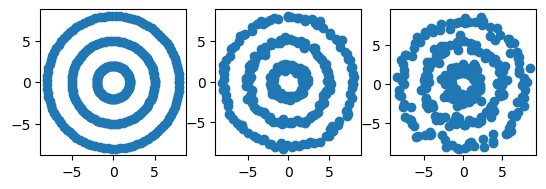

In [7]:
def create_concentric_discs_data(num_points_per_cluster, radii, noise_level):
    ''' Create concentric set of points with a given radius
    INPUT 
    num_points_per_cluster: integer, specifies how many points per each disc
    radii: vector real numbers, specifies the radius of each of the discs (and how many discs)
    noise_level: real number, specifies deviation level from the disc
    OUTPUT
    X: dataset, list of vectors each being the coordinates of one datapoint'''
    X = []
    thetas = np.linspace(0, 2*np.pi,num=num_points_per_cluster)
    for r in radii:
        for theta in thetas:
            X.append([r*np.cos(theta), r*np.sin(theta)]+noise_level*np.random.randn(2))
    return X


num_points_per_cluster = 100    # num points per class
radii = [2,5,8]                 # radii of the thee discs
noise_levels = [0,0.2,0.4]      # level of noise per each disc
for i,noise_level in enumerate(noise_levels):
    plt.subplot(1,len(noise_levels),i+1)
    X = create_concentric_discs_data(num_points_per_cluster, radii, noise_level)
    X_x,X_y = zip(*X)
    plt.scatter(X_x,X_y)
    plt.axis("square")

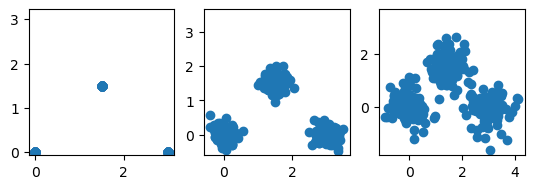

In [8]:
def create_clustered_blobs_data(num_points_per_cluster, centers, noise_level):
    ''' Create set of points around a given center 
    INPUT 
    num_points_per_cluster: integer, specifies how many points per each disc
    centers: list of vectors, specifies the coordinates of each of the centers
    noise_level: real number, specifies deviation level from the center
    OUTPUT
    X: dataset, list of vectors each being the coordinates of one datapoint'''
    X = []
    for c in centers:
        for _ in range(num_points_per_cluster):
            X.append(c+noise_level*np.random.randn(len(c)))
    return X


num_points_per_cluster = 100                # num points per class
centers = [[0,0], [1.5,1.5], [3,0]]         # centers of the thee blobs
noise_levels = [0,0.2,0.4]                  # level of noise per each disc
for i,noise_level in enumerate(noise_levels):
    plt.subplot(1,len(noise_levels),i+1)
    X = create_clustered_blobs_data(num_points_per_cluster, centers, noise_level)
    X_x,X_y = zip(*X)
    plt.scatter(X_x,X_y)
    plt.axis("square")

### Implement k-means clustering algorithm


Recall that, given coordinates $Y=[y_1,\dots,y_N]$ for the nodes and a clustering assignment $C$, the loss function for $k$-means is 
$$
f(Y, C) = \sum_{s = 1}^K \sum_{j: C(j)=s} \|y_j - m_s\|^2
$$

In [9]:
def index_closest_centroid(data_point,centroids):
    ''' Select the closest centroid to a given data point 
    INPUT
    data_point: vector with the coordinates of a given datapoint
    centroids: list of vectors with the coordinates of the given centroids 
    OUTPUT
    index: integer corresponding to the centroid closest to the datapoint '''
    
    
    # Get squared norm of each data point to each centroids
    distances = np.sum((centroids-data_point) ** 2, axis = 1)
    
    # Return lowest distances index
    return int(np.argmin(distances))

def assign_clusters(X,centroids):
    ''' Assign to each point the index of its nearest centroid
    INPUT
    X: dataset, list of vectors each being the coordinates of one datapoint
    centroids: list of vectors with the coordinates of the given centroids 
    OUTPUT 
    clusters: dictionary such that clsuters[k] = list of indices corresponding to the data points whose closest centroid is the k-th; clusters.keys() = [0,1,2,...,number_of_clusters]'''
    
    

    # Dictionary to store data points with closest centroid as the k-th index
    clusters = {k: [] for k in range(0,len(centroids))}

    # Loop over data points and assign it to the closest centroid
    for i in range(0, len(X)):
        clusters[index_closest_centroid(X[i], centroids)].append(i)
    
    return clusters

def compute_centroids(X,clusters):
    ''' Given the clusters, compute their centroids 
    INPUT
    X: dataset, list of vectors each being the coordinates of one datapoint
    clusters: dictionary such that clsuters[k] = list of indices corresponding to the data points whose closest centroid is the k-th; clusters.keys() = [0,1,2,...,number_of_clusters]
    OUTPUT 
    centroids: list of vectors with the coordinates of the given centroids '''
    
    
    # Create empty centroids multi-array that has same shape as old centroids
    centroids_new = np.empty((len(clusters), X.shape[1]), dtype = float)

    # Loop over clusters
    for k in clusters:
        # If clusters not empty
        if clusters[k]:
            # assign the centroids as the mean of the data points in that cluster
            centroids_new[k] = np.mean(X[clusters[k]], axis = 0)
        # If cluster empty
        else:
            # assign random initialisation from X
            centroids_new[k] = X[np.random.choice(len(X))]

    return centroids_new

def k_means_loss(X,clusters,centroids):
    ''' Evaluate the loss function of k-means given the dataset X, the current cluster assignment and the current centroids
    INPUT
    X: dataset, list of vectors each being the coordinates of one datapoint
    clusters: dictionary such that clsuters[k] = list of indices corresponding to the data points whose closest centroid is the k-th; clusters.keys() = [0,1,2,...,number_of_clusters]
    centroids: list of vectors with the coordinates of the given centroids
    OUTPUT
    loss: real value
    '''
    
    
    loss = 0
    # Loop over clusters
    for s in clusters:
        # Calculate squared norm of each cluster
        loss += np.sum((X[clusters[s]] - centroids[s])**2)

    return loss
    
def distance_between_centroids(centroids1, centroids2):
    ''' Compute the distance between two sets of centroids
    INPUT
    centroids1: list of vectors with the coordinates of the centroids 
    centroids2: list of vectors with the coordinates of the centroids 
    OUTPUT
    distance: real number measuring how far centrodis1 and centroids2 are
    '''
    
    

    # compute distance
    return np.linalg.norm(centroids1 - centroids2)

def k_means(X, centroids, number_of_steps = 30):
      ''' Executes number_of_steps runs of k-means algorithm '''
      loss_history = []
      centroids_distance_history = []
      for _ in range(number_of_steps):
        clusters = assign_clusters(X,centroids)
        loss_history.append(k_means_loss(X,clusters,centroids))
        new_centroids = compute_centroids(X,clusters)
        centroids_distance_history.append(distance_between_centroids(centroids,new_centroids))
        centroids = new_centroids
      return loss_history, centroids_distance_history, centroids

### Run k-means on the two synthetic datasets (discs and blobs) datasets and visualize its behaviour and its output

Create three plots that show
1. the k-means loss evolving over the iterations, 
1. the centroid distance evolving over the iterations, and
1. the data with final colour-coded clusters and centroid locations marked 
(see example figure below)

Blobs dataset first

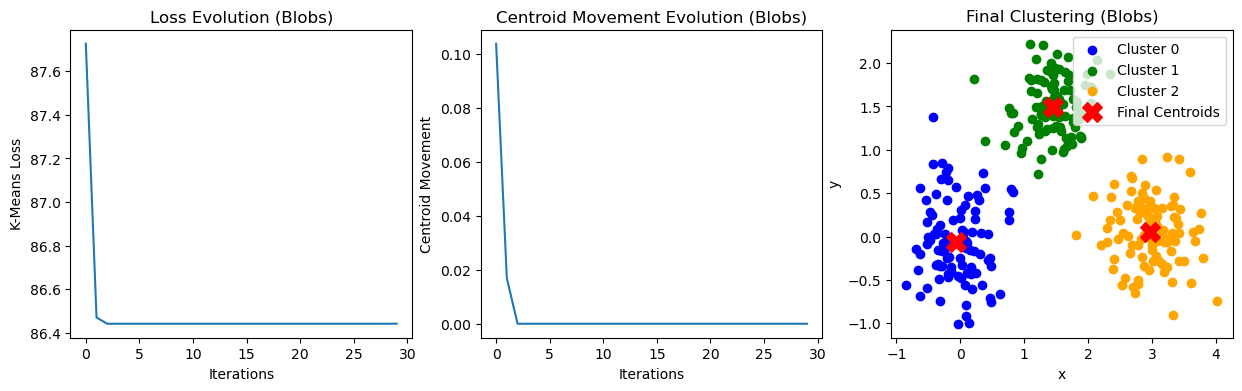

In [10]:
SEED = 8032004 # <- DDMMYYY
np.random.seed(SEED)

num_points_per_cluster = 100                # num points per class
centers = [[0,0], [1.5,1.5], [3,0]]         # centers of the thee blobs
noise_level = 0.4                           # level of noise per each disc
num_clusters = 3

X = np.array(create_clustered_blobs_data(num_points_per_cluster, centers, noise_level))
centroids = np.array(centers)
loss_blop, centroids_distance_blop, final_blop = k_means(X, centroids)


plt.figure(figsize=(15, 4))

# Plot 1: loss functions
plt.subplot(1, 3, 1)
plt.plot(loss_blop)
plt.xlabel("Iterations")
plt.ylabel("K-Means Loss")
plt.title("Loss Evolution (Blobs)")

# Plot 2: Centroid Distance over iterations
plt.subplot(1, 3, 2)
plt.plot(centroids_distance_blop)
plt.xlabel("Iterations")
plt.ylabel("Centroid Movement")
plt.title("Centroid Movement Evolution (Blobs)")

# Plot 3: data with fnal colour-coded clusters and centroid locations marked
plt.subplot(1,3,3)
# Get cluster assignment of the final centroid
clusters_blop = assign_clusters(X, final_blop)
colors = ['b', 'g', 'orange', 'c', 'm', 'y', 'k']  
for cluster_id, indices in clusters_blop.items():
    plt.scatter(X[indices, 0], X[indices, 1], label=f"Cluster {cluster_id}",color=colors[cluster_id])
plt.scatter(final_blop[:, 0], final_blop[:, 1], c='red', marker='X', s=200, label="Final Centroids")

plt.title("Final Clustering (Blobs)")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()

Discs dataset next

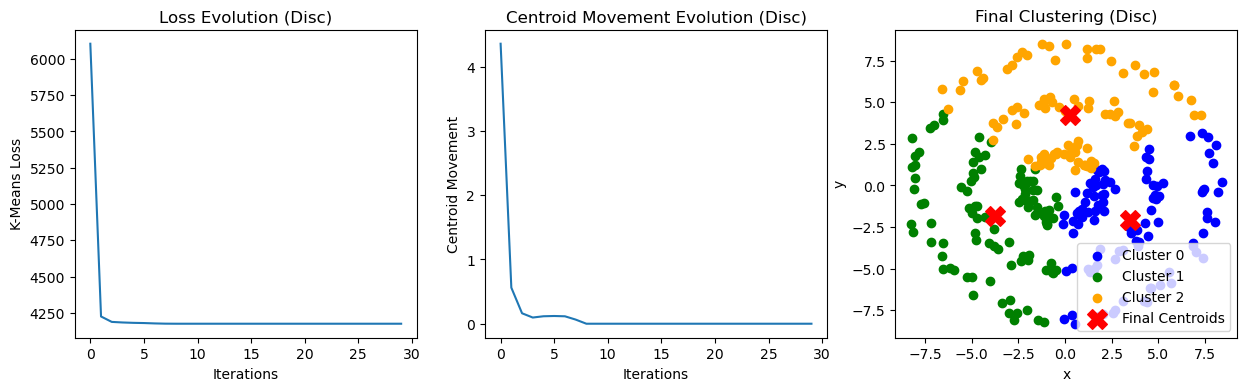

In [11]:
SEED = 8032004 # <- DDMMYYY
np.random.seed(SEED)

num_points_per_cluster = 100                # num points per class
radii = [2,5,8]                             # radii of the three discs
noise_level = 0.4                           # level of noise per each disc
num_clusters = 3

### Your code goes here ###
X_disc  = np.array(create_concentric_discs_data(num_points_per_cluster, radii, noise_level))
# Initialize random data points as centroid
centroids_disc = X_disc[np.random.choice(len(X_disc), num_clusters, replace=False)]
loss_disc, centroids_distance_disc, final_disc = k_means(X_disc, centroids_disc)

plt.figure(figsize=(15, 4))
# Plot 1: loss functions
plt.subplot(1, 3, 1)
plt.plot(loss_disc)
plt.xlabel("Iterations")
plt.ylabel("K-Means Loss")
plt.title("Loss Evolution (Disc)")

# Plot 2: Centroid Distance over iterations
plt.subplot(1, 3, 2)
plt.plot(centroids_distance_disc)
plt.xlabel("Iterations")
plt.ylabel("Centroid Movement")
plt.title("Centroid Movement Evolution (Disc)")

# Plot 3: data with fnal colour-coded clusters and centroid locations marked
plt.subplot(1,3,3)
# Get cluster assignment of the final centroid
clusters_disc = assign_clusters(X_disc, final_disc)
colors = ['b', 'g', 'orange', 'c', 'm', 'y', 'k']  
for cluster_id, indices in clusters_disc.items():
    plt.scatter(X_disc[indices, 0], X_disc[indices, 1], label=f"Cluster {cluster_id}",color=colors[cluster_id])
plt.scatter(final_disc[:, 0], final_disc[:, 1], c='red', marker='X', s=200, label="Final Centroids")

plt.title("Final Clustering (Disc)")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()

### Compute heat-kernel matrix and its knn version

Define a function `heatkernel_weight_matrix` that given a dataset $X$ with $N$ datapoints $y_i \in \mathbb R^d$ returns the heat kernel weight matrix of the similarity graph obtained by setting:
$$
    W_{ij} = \exp\left(\frac{-\|y_i-y_j\|^2}{\sigma^2}\right)
$$
if $i\neq j$ and $W_{ij}=0$ otherwise.

[Marks: 2]

In [12]:
def heatkernel_weight_matrix(X):
    ''' Compute the weight matrix of the graph
    INPUT
    X: Coordinates of the datapoints;  X[i] = y_i
    OUTPUT 
    W: Weight matrix with heat-kernel function as defined above
    '''
    
    N = X.shape[0]
    # Initialize NxN matrix for heat kernel weight matrix
    heat_matrix = np.zeros(shape=(N,N))
    sigma2 = 1
    
    for i in range(N):
        # compute only the upper triangular
        for j in range(i+1, N):
            # Calculate numerator norm squared
            dist_ij = np.sum((X[i]-X[j])**2)
            # due to symmetric structure
            heat_matrix[i,j] = heat_matrix[j,i] = np.exp(-dist_ij/sigma2)
    
    return heat_matrix   
    

Define a function `knn_weight_matrix` that given an initial weight matrix $W$ and a chosen number $k$ of nearest neighbours returns the new weight matrix of the graph obtained by setting to zero, for every node $i$, all the nodes that are further than the $k$-th closest neighbour. 
This function should have two modes:
- `mode="distance"`, returns the values of $W_{ij}$ as they are
- `mode="binary"`sets $W_{ij}=1$ if $X_j$ is one of the knn of $X_i$ 

In [13]:
def knn_weight_matrix(W,k,mode="binary"):
    '''Given a matrix W and an integer k returns a matrix W where smallest entries per each row are set to zero'''
    # HINT: You may consider using np.argsort(vec). It performs an indirect sort of the vector `vec' and returns an array of indices of the same shape as vec corresponding to the permutation that would rearrange the vector in the sorted order.

    ### Your code goes here ###
    # Initialize zero matrix 
    W_knn = np.zeros(W.shape)
    # Loop over rows
    for i in range(len(W)):
        # Index corresponding to the sorted ascending value of row i of W
        sort = np.argsort(W[i])
        if mode == "binary":
            W_knn[i, sort[-k:]] = 1 # set to 1 for the k largest value
        elif mode == "weighted":
            W_knn[i, sort[-k:]] = W[i, sort[-k:]] # set to W value for the k largest value
        else:
            print("mode do not exist")
            return

    return W_knn

The k-nearest-neighbour matrix is not symmetric in general. Define a function that verifies whether $W$ is symmetric and computes a symmetrized version of $W$ by setting $W_{ij}=W_{ji}$ whenever $W_{ij}=0$ and $W_{ji}>0$

In [14]:
def symmetrize(W):
    '''Return a symmetrized version of W or W itself if already symmetric
    INPUT
    W: Weight matrix with W_ij>0 
    OUTPUT:
    W: symmetrized version as described above'''
    N = W.shape[0]
    # Initialize NxN matrix for heat kernel weight matrix
    weight_symmetric = np.copy(W)
    
    ### Your code goes here ###
    # if not symmetric run:
    if (np.transpose(W) != W).any():
        # Loop over rows
        for i in range(N):
            # Loop over upper triangle column
            for j in range(i+1, N):
                # If W_ij = 0 and W_ji > 0
                if W[i,j] == 0 and W[j,i] >0:
                    weight_symmetric[i,j] = W[j,i]
                # If W_ji = 0 and W_ij > 0
                elif W[j,i] == 0 and W[i,j] >0:
                    weight_symmetric[j,i] = W[i,j]
                else:
                    continue
    else: # If W is already symmetric
        return weight_symmetric
        
    return weight_symmetric

### Generate an undirected $k$-nn graph from the three disc dataset and visualize it

Text(0.5, 1.0, 'Sparsity plot of knn W')

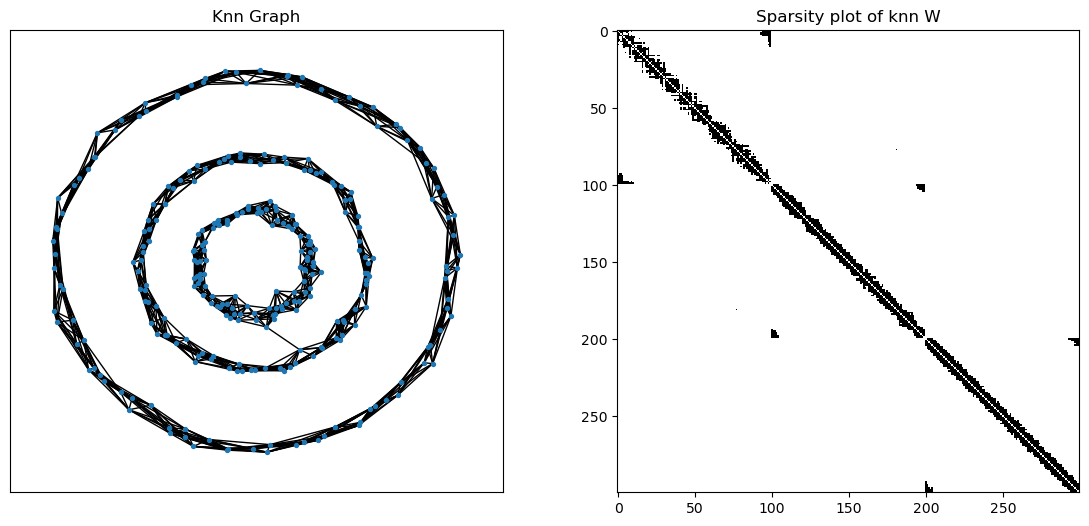

In [15]:
SEED = 8032004
np.random.seed(SEED)
num_points_per_cluster = 100    
radii = [2,4,7]                 
noise_level = 0.2      
number_nearest_neighbours = 10
## Graph generation and plotting functions here ###
X_disc  = np.array(create_concentric_discs_data(num_points_per_cluster, radii, noise_level))
W_disc = heatkernel_weight_matrix(X_disc)
W_disc_knn = knn_weight_matrix(W_disc, number_nearest_neighbours, mode = "binary")
W_sym = symmetrize(W_disc_knn)
G = nx.from_numpy_array(W_sym)

# Plot knn graph
plt.figure(figsize=(14, 6))
plt.subplot(1,2,1)
nx.draw_networkx(G, pos = X_disc, node_size = 8, with_labels = False)
plt.title("Knn Graph")

# Sparsity plot
plt.subplot(1,2,2)
plt.imshow(W_sym, cmap="gray_r", interpolation="nearest")
plt.title("Sparsity plot of knn W")

### Compute the eigenvectors of the graph Laplacian (and its normalized version) and apply k-means to the new embedding. Compare the results with k-means obtained with the initial representation.

Function that computes L and L_norm from a matrix W  

Recall that the normalized graph Laplacian is defined as $D^{-1/2}LD^{-1/2}$ where $L$ is the Laplacian and $D$ is the diagonal matrix of the (weighted) degrees of the graph

In [16]:
def get_Laplacians(W):
    '''Compute the Laplacian and the normalized Laplacian of the graph with weight matrix W'''

    # sum of rows
    d = np.sum(W, axis=0)
    D = np.diag(d)
    # Laplacian matrix
    L = D-W
    D_inv_sqrt = np.linalg.pinv(np.sqrt(D))
    # Normalized lapalcian matrix
    L_norm = D_inv_sqrt @ L @ D_inv_sqrt
    
    return L, L_norm

Compute the Laplacian from the `Wknn` matrix, compute its eigenvectors and compute the new embedding made by the coordinates of the eigenvectors corresponding to the three smallest eigenvalues. 

In [17]:
L,L_norm = get_Laplacians(W_sym)

# Use L_norm due to 
eigenvalues, eigenvectors = np.linalg.eig(L_norm)
# sort eigenvalues 
idx = np.argsort(eigenvalues)
# sort eigenvectors based on eigenvalues index
eigenvectors = eigenvectors[:,idx]
# take 3 eigenvector corresponding to 3 smallest eigenvalues
embedding = np.real(eigenvectors[:,0:3])

Normalized Laplacian is used as it ensures that all nodes are treated more equally in the spectral embedding. Furthermore, it also improves numerical stability.

Run k-means on the new embedding and visualize the result.

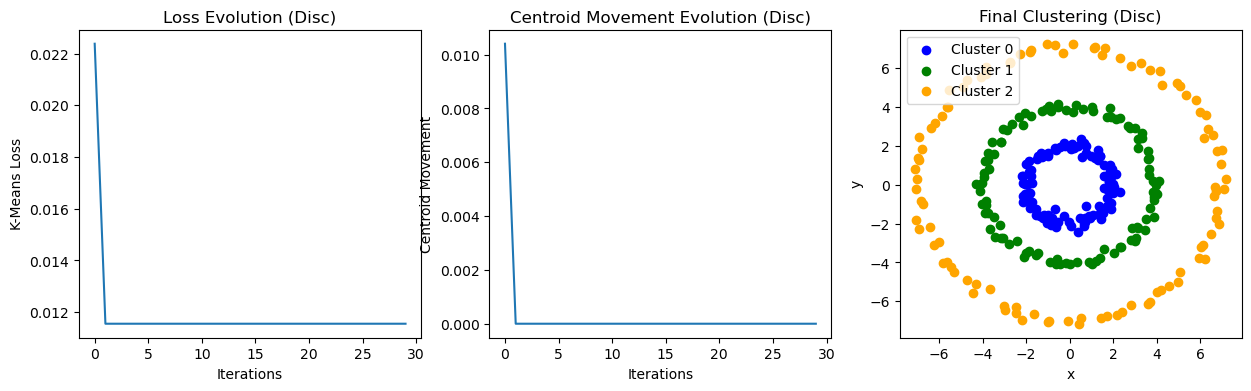

In [18]:
SEED = 8032004
np.random.seed(SEED)

# Initialize random centroid from the embedding
centroids_spectral = embedding[np.random.choice(len(embedding), 3, replace=False)]
# Run k means
loss_spectral, centroid_distance_spectral, final_spectral = k_means(embedding, centroids_spectral, number_of_steps=30)

plt.figure(figsize=(15, 4))
# Plot 1: loss functions
plt.subplot(1, 3, 1)
plt.plot(loss_spectral)
plt.xlabel("Iterations")
plt.ylabel("K-Means Loss")
plt.title("Loss Evolution (Disc)")

# Plot 2: Centroid Distance over iterations
plt.subplot(1, 3, 2)
plt.plot(centroid_distance_spectral)
plt.xlabel("Iterations")
plt.ylabel("Centroid Movement")
plt.title("Centroid Movement Evolution (Disc)")

# Plot 3: data with fnal colour-coded clusters and centroid locations marked
plt.subplot(1,3,3)
# Get cluster assignment of the final centroid
clusters_spectral = assign_clusters(embedding, final_spectral)
colors = ['b', 'g', 'orange', 'c', 'm', 'y', 'k']  
for cluster_id, indices in clusters_spectral.items():
    plt.scatter(X_disc[indices, 0], X_disc[indices, 1], label=f"Cluster {cluster_id}",color=colors[cluster_id])

plt.title("Final Clustering (Disc)")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()

### Task 6: Validation metrics 

In order to quantify the quality of the resulting clustering assignment, design functions that compute accuracy, precision and recall. Use the functions to quantify the quality of the clustering from the k-means and spectral algorithm. Use the ground truth clusters as baseline.

[Marks: 6]

Accuracy: 
Compute the ratio (number of correctly assigned points) / (total number of points). 

Precision: 
Per each class compute the ratio (number of correctly assigned points to that class) / (total number of points that I predicted were in that class). Then, take the mean over the precision of the classes.   
It can be summarized with the slogan:
True Positves / (True Positives + False Positives)

Recall: 
Per each class compute the ratio (number of correctly assigned points to that class) / (total number of points that really are in the class). Then, take the mean over the recall of the classes.   
It can be summarized with the slogan:
True Positves / (True Positives + False Negatives)


In [19]:
from scipy.stats import mode

def map_clusters_to_labels(predicted_clusters, true_labels):
    """
    Map k-means clusters to their most likely true labels using majority voting.

    INPUT:
    - predicted_clusters: np.array of cluster labels assigned by k-means
    - true_labels: np.array of actual digit labels

    OUTPUT:
    - mapped_predictions: np.array where each cluster ID is replaced with the most common true label
    """
    mapped_predictions = np.zeros_like(predicted_clusters)

    for cluster_id in np.unique(predicted_clusters):
        # Find all true labels in this cluster
        mask = (predicted_clusters == cluster_id)  # Indices of points in this cluster
        if np.sum(mask) > 0:  # If cluster has points, find the most common true label
            mapped_predictions[mask] = mode(true_labels[mask])[0]

    return mapped_predictions

def validation_metrics(clusters,true_classes):
    '''
    INPUT:
    classes = classes predicted by the k-means
    true_classes = true labels of the points
    OUTPUT:
    accuracy = percentage of correctly classified
    precision = mean statistical precision over the classes
    recall = Per each class compute the ratio (number of correctly assigned points to that class) / (total number of points that really are in the class). 
    Then, take the mean over the recall of the classes
    '''
    # Change clusters format from dict to np.array for easier comparison to true_classes
    N = len(true_classes)
    clusters_array = np.zeros(N, dtype=int)
    for cluster_id, indices in clusters.items():
        clusters_array[indices] = cluster_id

    # Relabel clusters through hungarian algorithm
    clusters_array =  map_clusters_to_labels(clusters_array, true_classes)
    # Number of correctly assigned points / total number of points
    accuracy = np.sum(clusters_array == true_classes) / N

    # Compute precision
    precision_scores = []
    unique_clusters = np.unique(clusters_array)
    
    for cluster in unique_clusters:
        # index of predictive clusters using boolean for comparison
        pred_clust = (clusters_array == cluster)
        # index of true clusters using boolean for comparison too
        true_clust = (true_classes == cluster)
        # if both pred_clust and true_clust both True add 1 to the sum, true positive
        TP = np.sum(pred_clust & true_clust)
        # if pred_clust is true but true_clust is false add 1 to the sum, false positive
        FP = np.sum(pred_clust & ~true_clust)
        # precision each cluster
        precision_clust = TP / (FP+TP) if (TP + FP) > 0 else 0
        precision_scores.append(precision_clust)

    # Get the mean!
    precision = np.mean(precision_scores)

    # Compute recall
    recall_scores = []
    unique_true_classes = np.unique(true_classes)

    for true_class in unique_true_classes:
        # Predicted class indices
        pred_clust = (clusters_array == true_class) 
        # True class indices
        true_clust = (true_classes == true_class) 
        # True Positives
        TP = np.sum(pred_clust & true_clust) 
        # False Negatives
        FN = np.sum(~pred_clust & true_clust) 
        # Compute recall for each clusters/class 
        recall_clust = TP / (TP + FN) if (TP + FN) > 0 else 0
        recall_scores.append(recall_clust)
    # Get the mean of recall values
    recall = np.mean(recall_scores)
    

    return accuracy, precision, recall

### Apply our functions to a real dataset!

Load the Scikit-lear Digits dataset.    
This dataset is made up of 1797 8x8 images. Each image is of a hand-written digit in gray-scale. 


Compute accuracy, precision and recall of the unsupervised clustering algorithm obtained by spectral embedding + kmeans on this data.

You can try the clustering algorithm **only using the normalized graph Laplacian** and with two choices of the number of k-nearest-neighbors = 7 and 15.

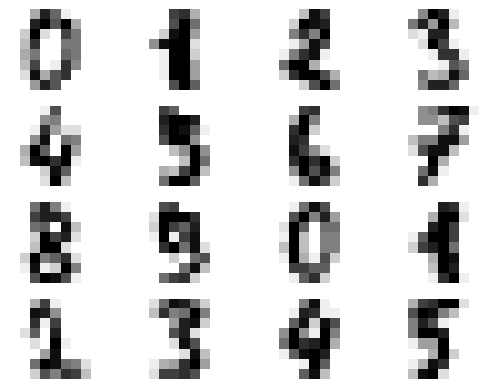

In [20]:
# Load the digits dataset
digits = datasets.load_digits()

# Display the first rxc images
c = 4
r = 4
for i in range(r*c): 
    plt.subplot(r,c,i+1)
    plt.imshow(digits['images'][i], cmap=plt.cm.gray_r, interpolation="nearest")
    plt.axis("off")

In [21]:
# Input
X = digits.data
# true label
y = digits.target

In [ ]:
def run_spectral_clustering(X, y, k_neighbors, num_clusters=10, number_of_steps = 30, mode = "binary"):
    """
    Runs spectral clustering on the Digits dataset with k-NN graph, computes validation metrics.
    
    Parameters:
        X: Data points (digits dataset)
        y: True labels
        k_neighbors: Number of nearest neighbors for k-NN graph
        num_clusters: Number of clusters (default=10 for Digits dataset)
    
    Returns:
        Accuracy, Precision, Recall
    """
    # Compute Heat Kernel Matrix
    W_dig = heatkernel_weight_matrix(X)

    # Compute k-NN Graph
    W_knn_dig = knn_weight_matrix(W_dig, k=k_neighbors, mode= mode)
    # Symmetrize it!
    W_sym_dig = symmetrize(W_knn_dig)
    # Compute Laplacian
    L_dig, L_norm_dig = get_Laplacians(W_sym_dig)

    # Compute Eigenvalues & Eigenvectors
    eigenvalues_dig, eigenvectors_dig = np.linalg.eig(L_norm_dig)
    idx = np.argsort(eigenvalues_dig)
    eigenvectors = eigenvectors_dig[:, idx]

    # Take the num_clusters smallest nonzero eigenvectors as embedding
    embedding_dig = np.real(eigenvectors[:, :num_clusters])
    
    # Run K-means on Spectral Embedding
    centroids_spectral_dig = embedding_dig[:num_clusters] # initialize centroids or you can change to random
    loss_spectral_dig, centroid_distance_spectral_dig, final_spectral_dig = k_means(embedding_dig, centroids_spectral_dig, number_of_steps)

    # Assign clusters
    clusters_spectral_dig = assign_clusters(embedding_dig, final_spectral_dig)

    # Compute Validation Metrics
    accuracy, precision, recall = validation_metrics(clusters_spectral_dig, y)
    
    return accuracy, precision, recall

In [23]:
SEED = 8032004
np.random.seed(SEED)
# Spectral clustering for k nearest neighbour = 7
acc_7, prec_7, rec_7 = run_spectral_clustering(X, y, k_neighbors=7, number_of_steps = 30)
print(f"Performance with k = 7:\n  Accuracy: {acc_7:.4f}, Precision: {prec_7:.4f}, Recall: {rec_7:.4f}")

Performance with k = 7:
  Accuracy: 0.8564, Precision: 0.9062, Recall: 0.8572


In [24]:
SEED = 8032004
np.random.seed(SEED)
# Spectral clustering for k nearest neighbour = 15
acc_15, prec_15, rec_15 = run_spectral_clustering(X, y, k_neighbors=15, number_of_steps = 30)
print(f"Performance with k = 15:\n  Accuracy: {acc_15:.4f}, Precision: {prec_15:.4f}, Recall: {rec_15:.4f}")

Performance with k = 15:
  Accuracy: 0.7691, Precision: 0.9077, Recall: 0.7668
